## スパースモデル(回帰係数が小さい説明変数が多いモデル)に対する馬蹄分布の挙動を確認する  
事前分布に馬蹄分布を設定することでベイズ的な変数選択を実現できる

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import arviz as az
import pandas as pd
import pytensor.tensor as pt
import numpyro

WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/opt/conda/envs/pymc-test/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#graphvizを使うためPATHを設定
import os
# Replace 'path_to_graphviz_bin' with the actual path to your Graphviz 'bin' directory.
# 仮想環境名が通常のPymc環境(/opt/conda/envs/pymc-dev/bin/)と違うため注意
graphviz_bin_path = '/opt/conda/envs/pymc-test/bin/'
# Append the Graphviz 'bin' directory to the PATH.
os.environ["PATH"] += os.pathsep + graphviz_bin_path

### ダミーデータ作成  
50次元　説明変数=50、その中で回帰係数(傾き)が０ではない変数の数は10とする  

In [3]:
D=50
D0=10

In [4]:
#乱数設定
SEED = 42

In [21]:
#切片を一様分布で生成(numpyでもPymcでも乱数生成はできる)
temp1 = pm.Uniform.dist(lower=-3, upper=3)
INTERCEPT = pm.draw(temp1,random_seed=SEED)

In [27]:
#傾きを生成　50次元の0ベクトルを作成
COEF = np.zeros(D)

In [28]:
#生成した傾きを確認
print(COEF)
print(COEF.shape)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
(50,)


In [29]:
# D0(回帰係数(傾き)が0ではない変数)はまだ中身0
COEF[:D0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [113]:
#D0(10次元)の一様分布(-1,1)
temp5 = pm.Uniform.dist(lower=-1, upper=1,size=D0)

In [114]:
#D0(回帰係数(傾き)が0ではない変数)を生成
#D0(10次元)の一様分布(-1,1)と正規分布(平均=5,分散=1)を乗算して生成
temp2 = pm.Normal.dist(mu=5,sigma=1,size=D0)
COEF[:D0] = pm.draw(temp5,random_seed=SEED) * pm.draw(temp2,random_seed=SEED)

In [115]:
# D0(回帰係数(傾き)が0ではない変数)の中身を確認
COEF[:D0]

array([ 4.51611471,  4.60763414,  3.78760763, -1.4933244 ,  5.87799467,
       -3.43797199,  3.64449922,  2.50283183, -3.69226731, -1.19165936])

切片(Intercept)、50次元の傾き(COEF):40個が傾き0,10個が傾きあり作成完了

##### 説明変数(観測データ)x(100次元)を生成する　正規分布(mu=0,sigma=1)

In [116]:
N=100

In [117]:
# N×Dの正規分布を作成(100×50次元の行列)
temp3 = pm.Normal.dist(mu=0,sigma=1,size=(N,D))
X = pm.draw(temp3,random_seed=SEED)

In [118]:
# Xを確認
print(X)
print(X.shape)

[[ 0.41832997  0.60557617  0.02878786 ... -0.09963476 -0.25769078
  -1.58951869]
 [-1.81491229  0.53617305  1.27138979 ... -0.74439149  1.30574661
   0.87000251]
 [ 0.79849565  0.83417813 -0.37099355 ... -0.52300382  1.83535089
  -1.43337649]
 ...
 [ 1.23510094  1.67676394  0.94802985 ... -0.8526332  -0.61437253
  -0.55967114]
 [ 0.98913696 -0.14552447  1.1913258  ...  0.57993091 -1.06476233
   0.57430918]
 [-0.89516259 -0.24351139 -0.26598902 ... -1.00121534  0.57711201
   1.69760976]]
(100, 50)


In [131]:
# 線形回帰モデルの誤差項は正規分布(平均=0,分散=1)とする 100行のベクトル
temp4 = pm.Normal.dist(mu=0,sigma=1,size=N)

In [132]:
# 観測データ(y)を作成する 切片+X @(内積) 傾き +誤差項
y = INTERCEPT + pt.dot(X, COEF) + pm.draw(temp4,random_seed=SEED)

In [133]:
y.type

TensorType(float64, shape=(100,))

In [134]:
# pytensolの中身を確認したい場合はeval()を使う
y.eval()

array([ 10.83331037,  16.36905335,  21.06399478, -12.13912436,
       -10.64955212,  18.56130189,  10.11939695,   0.32461919,
         5.28685793,  -4.08017977, -14.06357483,  13.1562138 ,
        18.82961556,  -4.50476566,   2.89227511,  -4.14251944,
        -4.52570923,  -2.48370452,  14.55909186, -24.02833043,
         7.63018962,  -1.08958543, -14.29677634,   4.56664025,
         2.96970935,   6.31842129,   1.60218247,   8.52642969,
         7.34800891, -12.89814092,   7.63629194,  12.93896344,
         2.70010971,  -1.01527076,   9.57031922,  16.62585339,
         7.35497408,   6.20009219,   0.45127834,   4.82593133,
         6.33345161,  18.4651643 ,   5.98635579,   6.10196479,
       -17.8792933 ,   3.34869833,  31.01601474,   3.47011161,
         8.79843643, -14.62931186,  -1.81741073,  19.30806311,
         9.7441828 ,   5.76090519, -11.38118954, -19.34350278,
        -8.37727271,   1.13382023,  20.04247216,   7.21876954,
         5.10431166,  -8.72413749,  22.13746444,   1.21

#### 生成した傾きを確認する

In [123]:
print(X[:,1].shape)
print(y.type)

(100,)
Vector(float64, shape=(100,))


In [124]:
X[:,1]

array([ 6.05576174e-01,  5.36173047e-01,  8.34178127e-01, -4.08709267e-01,
        8.19524515e-01,  1.46114905e+00,  2.12424471e-01,  4.47110034e-02,
        1.05275919e+00, -1.04356588e-01,  7.82121122e-01,  9.62698007e-01,
        1.01658209e+00, -2.84825610e-01,  2.78650582e-01,  6.37793839e-01,
       -4.10870351e-01, -1.78611003e+00,  3.11330983e-01, -1.01893334e+00,
        1.79536626e+00,  1.10343487e-01, -1.58961929e+00, -5.45762464e-01,
        1.11571176e+00, -1.34418621e+00,  9.77150410e-01,  8.89781304e-01,
        4.07476335e-01, -2.04979258e+00,  6.75650730e-01,  5.24919436e-01,
        7.10950841e-02,  5.01291838e-04,  1.00024814e+00, -7.99217272e-01,
       -1.80072490e-01, -3.61268478e-01, -2.91418250e-01,  4.29861567e-02,
        3.42396149e-01,  2.00879837e-02,  8.57283602e-01, -7.20755150e-01,
       -1.97182812e-01,  1.82370853e-01,  5.80326898e-01, -3.92071766e-01,
        2.89408703e+00, -1.43460464e+00, -4.35355530e-01,  1.87091922e-02,
        2.26521277e-01,  

In [125]:
# yはtensorのためeval()で中身を取り出す
y.eval()

array([ 10.83331037,  16.36905335,  21.06399478, -12.13912436,
       -10.64955212,  18.56130189,  10.11939695,   0.32461919,
         5.28685793,  -4.08017977, -14.06357483,  13.1562138 ,
        18.82961556,  -4.50476566,   2.89227511,  -4.14251944,
        -4.52570923,  -2.48370452,  14.55909186, -24.02833043,
         7.63018962,  -1.08958543, -14.29677634,   4.56664025,
         2.96970935,   6.31842129,   1.60218247,   8.52642969,
         7.34800891, -12.89814092,   7.63629194,  12.93896344,
         2.70010971,  -1.01527076,   9.57031922,  16.62585339,
         7.35497408,   6.20009219,   0.45127834,   4.82593133,
         6.33345161,  18.4651643 ,   5.98635579,   6.10196479,
       -17.8792933 ,   3.34869833,  31.01601474,   3.47011161,
         8.79843643, -14.62931186,  -1.81741073,  19.30806311,
         9.7441828 ,   5.76090519, -11.38118954, -19.34350278,
        -8.37727271,   1.13382023,  20.04247216,   7.21876954,
         5.10431166,  -8.72413749,  22.13746444,   1.21

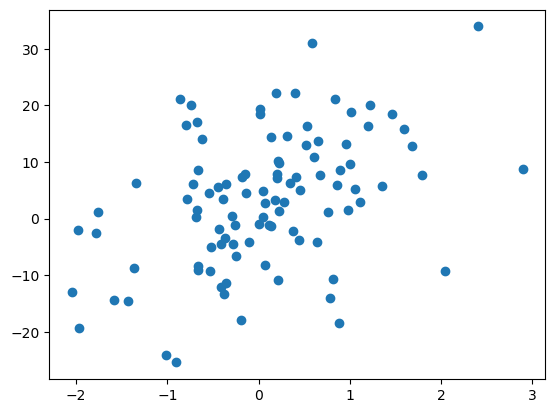

In [126]:
# β1とyの散布図をプロット
plt.scatter(X[:,1],y.eval())

In [127]:
# numpyの乱数生成インスタンスを作成
rng = np.random.default_rng(seed=SEED)

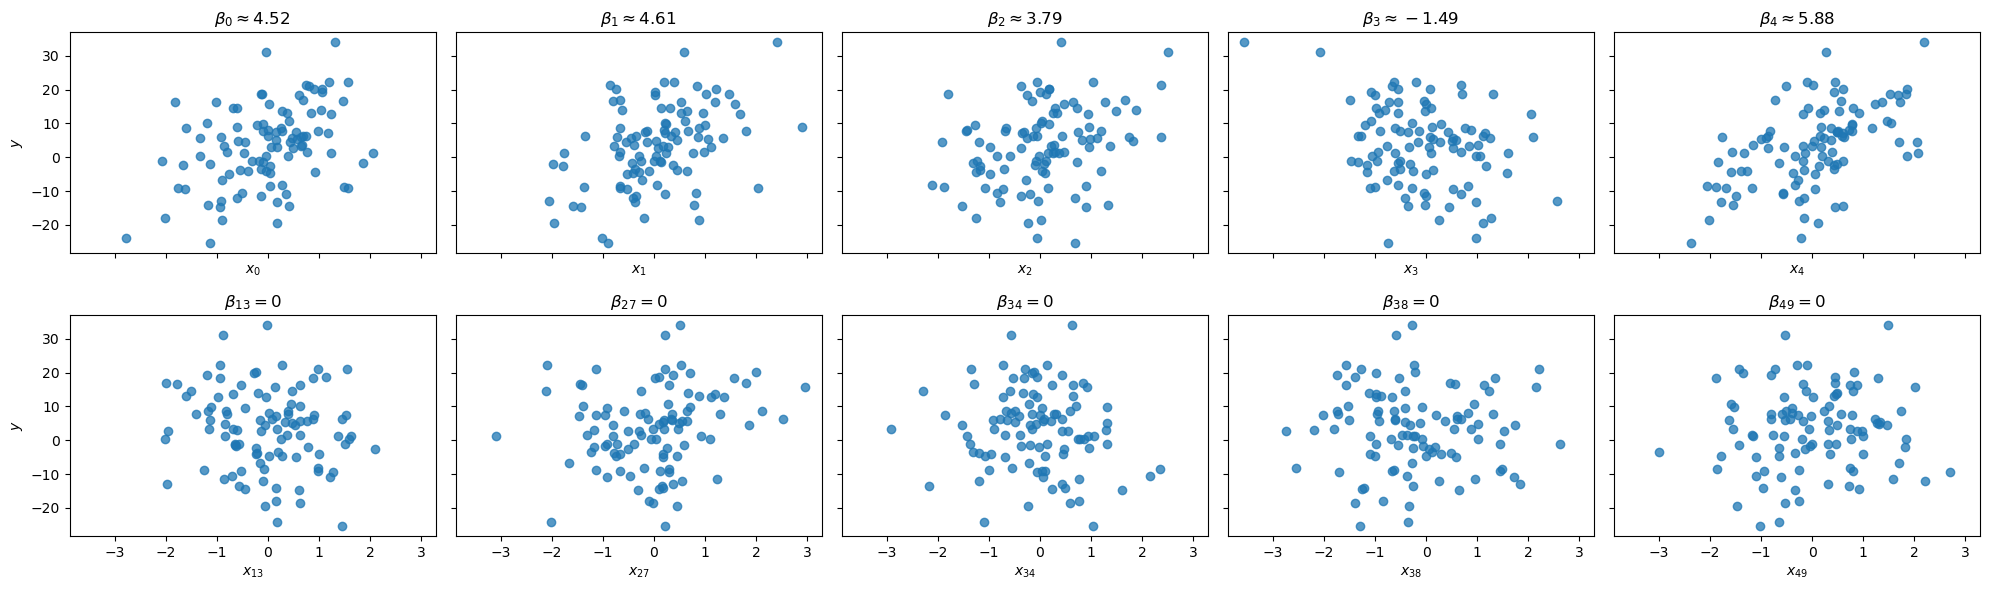

In [128]:
#傾きがある説明変数と傾きがない説明変数の散布図をランダムでそれぞれ5つ表示

fig, axes = plt.subplots(nrows=2, ncols=D0-5,
                         sharex=True, sharey=True,
                         figsize=(20, 6))

for i, (ax, coef) in enumerate(zip(axes[0], COEF)):
    ax.scatter(X[:, i], y.eval(), alpha=0.75);
    
    ax.set_xlabel(f"$x_{{ {i} }}$");
    ax.set_title(f"$\\beta_{{ {i} }} \\approx {coef:.2f}$");

#ランダムでインデックスを取得すらためNumpyの乱数生成を利用
zero_coef_ix = rng.choice(range(D0, D), replace=False, size=D0-5)
zero_coef_ix.sort()

for ax, i in zip(axes[1], zero_coef_ix):
    ax.scatter(X[:, i], y.eval(), alpha=0.75);
    
    ax.set_xlabel(f"$x_{{ {i} }}$");
    ax.set_title(f"$\\beta_{{ {i} }} = 0$");
    
axes[0, 0].set_ylabel("$y$");
axes[1, 0].set_ylabel("$y$");

fig.tight_layout();

β<sub>0</sub>～β<sub>4</sub>まで相関がありそう(傾きあるから想定通り)  
ランダムに抽出したβ<sub>13</sub>,β<sub>27</sub>は相関が無いよ鵜に見える(傾き0なので想定通り)

### モデル作成
事前分布:階層ホースシュー分布のモデルを作成する

In [239]:
model1 = pm.Model()

In [240]:
with model1:
    X_data = pm.Data('X_data',X)
    y_data = pm.Data('y_data',y.eval())

In [241]:
#誤差項として半正規事前分布(σ=2.5)を設定 
with model1:
    σ = pm.HalfNormal('σ',sigma=2.5)

階層正則化ホースシューでは,グローバルとローカルの２つのレベルの正則化が使用される  
各係数のローカルパラメータλiとともに(リッジ回帰と同様に),  
すべてのパラメータをゼロに向かって縮小するグローバルパラメータτがある  
λiのロングテール事前分布により,τのスケールによって事前に予想される非ゼロパラメータの数が設定され、一部のpパラメータが非ゼロになることが許可される

非ゼロパラメータの数の選び方  
元論文  Piironen, J., & Vehtari, A. (2017). Sparsity information and regularization in the horseshoe and other shrinkage priors. Electronic Journal of Statistics, 11(2), 5018-5051

モデルがより複雑になると、参照結果(3.12)は線形モデル(2.1)を仮定して導かれているため、ハイパープリファイヤーの選択の指針として単純に使用することはできない  
目的のモデルについて同様の結果が簡単に導けない限り、我々は、異なるτの値について事前分布から描画し、スパース性（どれだけの係数がある閾値を下回るのか）への影響を調べ、妥当な値の範囲のアイデアを得るという実用的なアプローチを推奨する  
この戦略は粗雑に見えるかもしれないが、それでも事前分布を全く考えないよりは良いはずだと我々は主張する  
さらに、我々の結果(第4.2節)は、τ ∼ C+(0,τ<sup>2</sup>)のような弱い情報量の事前分布を持つ場合、τ0の正しい大きさを大まかにでも把握することは、単純なτ ∼ C(0, 1)に比べて明らかな改善となることを示唆している
→おおよそでもいいから非ゼロパラメータの数を決める？

元論文に記載の欠点  
Lassoの明確な利点は、これらの問題に対して計算時間が1秒未満と非常に高速であることです  
一方、正則化された馬蹄形であっても、2つの最も大きな問題（ProstateとLeukemiaデータセットに対して約30～60分）では計算がかなり複雑になり始め、これは完全なベイズ推論の代償となる
→ベイズ推論の場合、ラッソ回帰と比べて計算に時間がかかる

グローバルパラメータτの事前設定にハーフスチューデントT分布を設定  
$D_*$はゼロ以外の係数の数(今回の場合はD0:傾きがある説明変数の数を利用する)  
現実世界ではD0は不明だがD0が大きすぎない限り、うまく機能するのでおおよその値を設定する

$$
τ \sim \textrm{HalfStudentT}\left(\frac{D_*}{D-D_*} \cdot \frac{\sigma}{\sqrt{N}}\right)
$$

In [242]:
with model1:
    τ = pm.HalfStudentT('τ', 2, D0 / (D - D0) * σ / np.sqrt(N))

#### 正則化馬蹄分布の事前分布
$$
    \beta_i \sim N\left(0, \tau^2 \cdot \tilde{\lambda}_i^2\right)
$$

$\tilde{\lambda}_i$(係数)は  

$$
\tilde{\lambda}_i = \frac{c^2 \lambda_i}{c^2 + \tau^2 \lambda_i}
$$

各係数のローカルパラメータ$\lambda_i$の事前分布はロングテール事前分布の$\lambda_i \sim \textrm{Half-StudentT}(5)$を使う

In [243]:
with model1:
    λ = pm.HalfStudentT('λ', 5, shape=D)

§2.3 of Piironen and Vehtariの元論文(2.3章)によると$c^2$には逆ガンマ分布を使う  
$c^2 \sim \textrm{InverseGamma}(1, 1)$

In [244]:
with model1:
    c2 = pm.InverseGamma('c2', 1, 1)

↑で定義した事前分布を使って正則化馬蹄分布のパラメータ$\tilde{\lambda}_i$を定義する

In [245]:
with model1:
    λ_ = λ * pt.sqrt(c2 / (c2 + τ**2 * λ**2))

傾き($\beta_i \sim N\left(0, \tau^2 \cdot \tilde{\lambda}_i^2\right)$)を実装するためパラメータ化を使う  
$\beta_i$は観測データy:(尤度)(正規分布を設定)の平均($\mu$)になる

$$
z_i \sim N(0, 1), \\
\beta_i = z_i \cdot \tau \cdot \tilde{\lambda_i}
$$

In [246]:
with model1:
    z = pm.Normal('z', 0., 1., shape=D)
    β = pm.Deterministic('β', z * τ * λ_)

3つの要素$z_i,\tau,\tilde{\lambda_i}$のうち2つが正の値になるように制約することが重要であることに注意  
そうしなければこのモデルは完全に識別されない  
PiironeやVehtariと異なり$\tau,\tilde{\lambda_i}$に半スチューデントT分布を使用することで識別可能性を強化している

切片に比較的平坦な$N(0, 10^2)$事前を使用すると観測データの尤度は次のようになる

In [247]:
with model1:
    intercept = pm.Normal('intercept', 0, 10)
    obs = pm.Normal('obs', intercept + pt.dot(X_data, β), σ, observed=y_data)

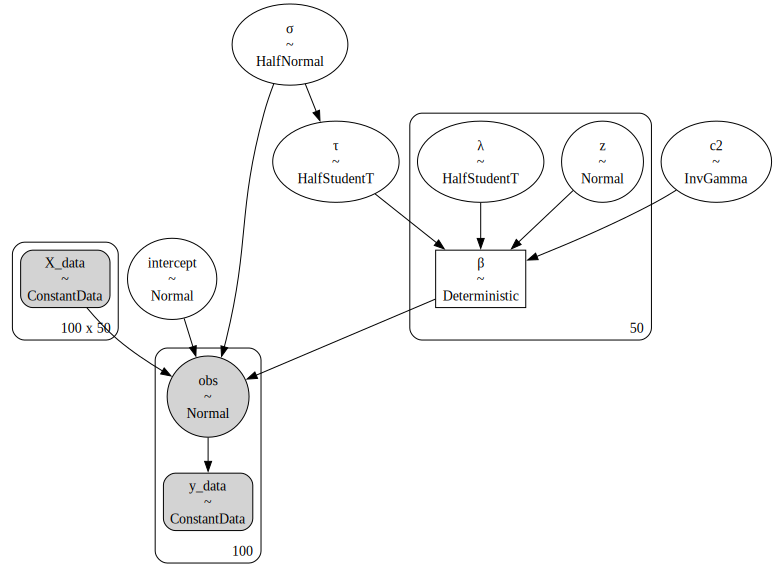

In [248]:
pm.model_to_graphviz(model1)

サンプルを実施

In [249]:
%%time
with model1:
     idata1 = pm.sample(4000,target_accept=0.99,nuts_sampler="blackjax",random_seed=42,idata_kwargs={"log_likelihood": True})

/opt/conda/envs/pymc-test/lib/python3.11/site-packages/pytensor/tensor/elemwise.py:754: RuntimeWarning: divide by zero encountered in divide
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/opt/conda/envs/pymc-test/lib/python3.11/site-packages/pytensor/tensor/elemwise.py:754: RuntimeWarning: divide by zero encountered in divide
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Compiling...
/opt/conda/envs/pymc-test/lib/python3.11/site-packages/pytensor/tensor/elemwise.py:754: RuntimeWarning: divide by zero encountered in divide
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/opt/conda/envs/pymc-test/lib/python3.11/site-packages/pymc/sampling/jax.py:459: UserWarning: BlackJax currently only display progress bar correctly under `chain_method == 'vectorized'`. Setting `progressbar=False`.
  warnings.warn(
Compilation time = 0:00:01.750066
Sampling...
Sampling time = 0:00:13.889521
Transforming variables...
Transformation time = 0:00:00.125551
Computing Log Likelihood...
Log Likelihood t

CPU times: user 44 s, sys: 170 ms, total: 44.2 s
Wall time: 17 s


<Axes: >

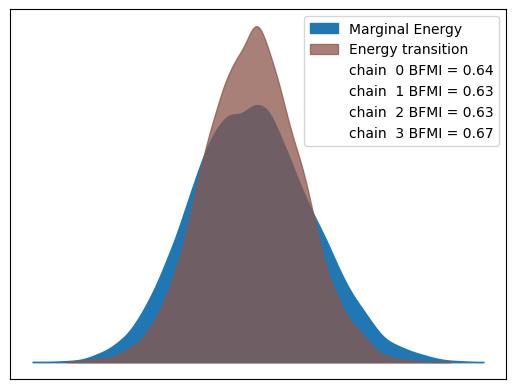

In [250]:
az.plot_energy(idata1)

In [252]:
summary1 = az.summary(idata1,var_names=['σ','τ','λ','intercept','β'])
display(summary1)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
σ,0.926,0.088,0.762,1.090,0.001,0.001,13285.0,11215.0,1.0
τ,0.770,0.164,0.493,1.088,0.002,0.001,7812.0,10714.0,1.0
λ[0],3.686,1.652,1.479,6.512,0.016,0.012,13530.0,11237.0,1.0
λ[1],3.603,1.561,1.441,6.262,0.014,0.011,14069.0,11361.0,1.0
λ[2],3.084,1.365,1.117,5.362,0.013,0.010,13175.0,11430.0,1.0
...,...,...,...,...,...,...,...,...,...
β[45],-0.033,0.088,-0.215,0.129,0.001,0.000,16807.0,15319.0,1.0
β[46],-0.093,0.105,-0.305,0.084,0.001,0.001,12801.0,15453.0,1.0
β[47],-0.120,0.113,-0.337,0.069,0.001,0.001,12498.0,14174.0,1.0
β[48],-0.074,0.112,-0.293,0.131,0.001,0.001,14346.0,13975.0,1.0


In [253]:
#Rhatを確認
az.rhat(idata1).max()

<xarray.Dataset> Size: 56B
Dimensions:    ()
Data variables:
    z          float64 8B 1.001
    intercept  float64 8B 1.0
    σ          float64 8B 1.0
    τ          float64 8B 1.0
    λ          float64 8B 1.001
    c2         float64 8B 1.0
    β          float64 8B 1.001

In [256]:
idata1

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data

In [ ]:
summary1 = az.summary(idata1,var_names=['σ','τ','λ','intercept','β'])
display(summary1)

In [272]:
az.summary(idata1,var_names=['β'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β[0],4.548,0.130,4.303,4.788,0.001,0.001,15684.0,15490.0,1.0
β[1],4.453,0.122,4.236,4.692,0.001,0.001,16037.0,14559.0,1.0
β[2],3.621,0.148,3.331,3.894,0.001,0.001,13836.0,14149.0,1.0
β[3],-1.533,0.128,-1.773,-1.296,0.001,0.001,15230.0,14581.0,1.0
β[4],5.939,0.109,5.734,6.141,0.001,0.001,15907.0,13466.0,1.0
β[5],-3.496,0.139,-3.752,-3.229,0.001,0.001,15837.0,15069.0,1.0
β[6],3.424,0.136,3.171,3.684,0.001,0.001,15156.0,14847.0,1.0
β[7],2.525,0.143,2.257,2.794,0.001,0.001,14455.0,13329.0,1.0
β[8],-3.612,0.121,-3.833,-3.380,0.001,0.001,14890.0,14440.0,1.0
β[9],-1.187,0.124,-1.427,-0.959,0.001,0.001,15521.0,13706.0,1.0


In [ ]:
array([ 4.51611471,  4.60763414,  3.78760763, -1.4933244 ,  5.87799467,
       -3.43797199,  3.64449922,  2.50283183, -3.69226731, -1.19165936])

In [278]:
#model1のサンプラーのトレース結果
az.plot_posterior(idata1, var_names=['β0'])

KeyError: 'var names: "[\'β0\'] are not present" in dataset'